In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "Nin-like"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [7]:
USE_FULL_DF = True

if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
else:
    dataset_ = pd.read_csv(df_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
dataset.head()

,id,sequence,length,class
0,Achn019631,MEDGSFTPNTLLETLSDNTMDFDLMDELFYDGYWLETTEGPNFWQS...,940,1
1,Achn045931,MHIIVSKYIKDFGYDLSKFDRAKNLTLSPIIRIFDQQLSSTDTFDH...,263,1
2,Achn046361,MAEYPLAHFARKYRLKGCFAINLRSKYTGNDDYVLEIFLPDSNKDK...,460,1
3,Achn046371,MAVLLKQEKNDNKAHKKASVEMKRDLRLLLNIYKLPLALTWVSCGA...,642,1
4,Achn046381,MAVILKQEMNNNNAHQYAFLEIRWVLDRVRGIYKLPLALTWVPCGA...,652,1


In [8]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [9]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [10]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
3581,0.002312,0.003468,0.002312,0.004624,0.002312,0.004624,0.000000,0.001156,0.005780,0.008092,...,0.001156,0.000000,0.001156,0.001156,0.002312,0.001156,0.002312,0.0,0.0,0.002312
2533,0.003436,0.003436,0.003436,0.000000,0.006873,0.003436,0.000000,0.000000,0.000000,0.010309,...,0.000000,0.003436,0.000000,0.000000,0.003436,0.003436,0.000000,0.0,0.0,0.000000
4587,0.009404,0.006270,0.003135,0.003135,0.000000,0.006270,0.003135,0.000000,0.000000,0.000000,...,0.003135,0.000000,0.003135,0.000000,0.000000,0.006270,0.000000,0.0,0.0,0.000000
1712,0.024096,0.003012,0.006024,0.003012,0.006024,0.003012,0.003012,0.012048,0.003012,0.012048,...,0.000000,0.000000,0.000000,0.006024,0.000000,0.000000,0.000000,0.0,0.0,0.000000
2122,0.008032,0.004016,0.000000,0.000000,0.000000,0.000000,0.000000,0.008032,0.000000,0.000000,...,0.004016,0.000000,0.004016,0.000000,0.004016,0.000000,0.000000,0.0,0.0,0.000000


In [11]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (4401, 441)
X_test: (1101, 441)
y_train: (4401,)
y_test: (1101,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [12]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 23s 441ms/step - accuracy: 0.5781 - loss: 0.6929

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5516 - loss: 0.6894   

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5932 - loss: 0.6769 - val_accuracy: 0.8967 - val_loss: 0.3816


Epoch 2/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8750 - loss: 0.4257

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9052 - loss: 0.3005

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9088 - loss: 0.2807 - val_accuracy: 0.9376 - val_loss: 0.1562


Epoch 3/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0607

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9500 - loss: 0.1340

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9509 - loss: 0.1335 - val_accuracy: 0.9489 - val_loss: 0.1169


Epoch 4/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9375 - loss: 0.1053

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9658 - loss: 0.0933

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9662 - loss: 0.0952 - val_accuracy: 0.9614 - val_loss: 0.0936


Epoch 5/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9688 - loss: 0.0917

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9724 - loss: 0.0867

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9713 - loss: 0.0875 - val_accuracy: 0.9625 - val_loss: 0.0949


Epoch 6/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9688 - loss: 0.0710

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9768 - loss: 0.0742

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9772 - loss: 0.0722 - val_accuracy: 0.9625 - val_loss: 0.0992


Epoch 7/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9688 - loss: 0.0723

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9774 - loss: 0.0666

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9783 - loss: 0.0657 - val_accuracy: 0.9716 - val_loss: 0.0892


Epoch 8/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0919

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9879 - loss: 0.0486

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9875 - loss: 0.0474 - val_accuracy: 0.9728 - val_loss: 0.0863


Epoch 9/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9688 - loss: 0.0334

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9856 - loss: 0.0352

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9861 - loss: 0.0368 - val_accuracy: 0.9591 - val_loss: 0.1102


Epoch 10/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9688 - loss: 0.0720

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9810 - loss: 0.0517

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9813 - loss: 0.0515 - val_accuracy: 0.9750 - val_loss: 0.0875


Epoch 11/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0250

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9925 - loss: 0.0300

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9919 - loss: 0.0311 - val_accuracy: 0.9728 - val_loss: 0.0909


Epoch 12/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9844 - loss: 0.0396

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9885 - loss: 0.0285

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9898 - loss: 0.0287 - val_accuracy: 0.9750 - val_loss: 0.0921


Epoch 13/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0061

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9971 - loss: 0.0214

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0205 - val_accuracy: 0.9739 - val_loss: 0.1111


Epoch 14/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0033

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9920 - loss: 0.0228

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9926 - loss: 0.0217 - val_accuracy: 0.9603 - val_loss: 0.1618


Epoch 15/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9844 - loss: 0.0293

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9933 - loss: 0.0240

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9941 - loss: 0.0217 - val_accuracy: 0.9728 - val_loss: 0.1184


Epoch 16/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0018

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0137

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9957 - loss: 0.0152 - val_accuracy: 0.9762 - val_loss: 0.0974


Epoch 17/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9844 - loss: 0.0339

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9944 - loss: 0.0180

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9950 - loss: 0.0171 - val_accuracy: 0.9739 - val_loss: 0.1055


Epoch 18/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0045

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9922 - loss: 0.0197

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9930 - loss: 0.0183 - val_accuracy: 0.9705 - val_loss: 0.1346


Epoch 19/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0029

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0126

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9961 - loss: 0.0128 - val_accuracy: 0.9716 - val_loss: 0.1148


Epoch 20/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0028

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0151

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0131 - val_accuracy: 0.9682 - val_loss: 0.1217


Epoch 21/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0023

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0058

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0067 - val_accuracy: 0.9762 - val_loss: 0.1284


Epoch 22/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0015

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9979 - loss: 0.0083

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0083 - val_accuracy: 0.9739 - val_loss: 0.1167


Epoch 23/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0013

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0047

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0058 - val_accuracy: 0.9716 - val_loss: 0.1228


Epoch 24/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0017

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0053

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0073 - val_accuracy: 0.9762 - val_loss: 0.1195


Epoch 25/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0013

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0100

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9964 - loss: 0.0122 - val_accuracy: 0.9694 - val_loss: 0.1462


Epoch 26/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0032

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0073

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9961 - loss: 0.0112 - val_accuracy: 0.9773 - val_loss: 0.1017


Epoch 27/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0011

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9954 - loss: 0.0121

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9950 - loss: 0.0126 - val_accuracy: 0.9637 - val_loss: 0.1583


Epoch 28/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9844 - loss: 0.0183

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9957 - loss: 0.0101

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0108 - val_accuracy: 0.9728 - val_loss: 0.1240


Epoch 29/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0022

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9799 - loss: 0.0599

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9811 - loss: 0.0563 - val_accuracy: 0.9705 - val_loss: 0.1067


Epoch 30/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0066

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9954 - loss: 0.0128

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9950 - loss: 0.0139 - val_accuracy: 0.9716 - val_loss: 0.1314


Epoch 31/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0029

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9951 - loss: 0.0131

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9955 - loss: 0.0123 - val_accuracy: 0.9762 - val_loss: 0.1088


Epoch 32/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0012

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0014

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9762 - val_loss: 0.1158


Epoch 33/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0010

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0023

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0021 - val_accuracy: 0.9762 - val_loss: 0.1280


Epoch 34/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0016

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 7.7913e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 7.2945e-04 - val_accuracy: 0.9773 - val_loss: 0.1322


Epoch 35/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1431e-04

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 6.6728e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 6.5867e-04 - val_accuracy: 0.9773 - val_loss: 0.1343


Epoch 36/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3105e-04

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 3.1121e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 3.0649e-04 - val_accuracy: 0.9773 - val_loss: 0.1367



[Train Accuracy: 100.00% - Test Accuracy: 97.28%]


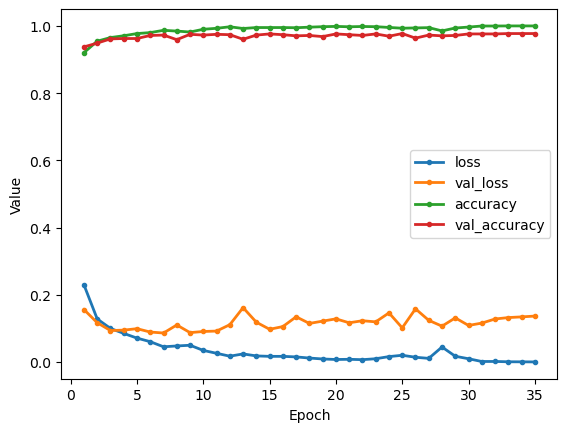

In [13]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [14]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [15]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
3581,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2533,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.003448,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4587,0.006289,0.0,0.0,0.003145,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1712,0.006042,0.0,0.0,0.000000,0.0,0.0,0.0,0.003021,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2122,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (4401, 8765)
X_test: (1101, 8765)
y_train: (4401,)
y_test: (1101,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [17]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,244,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,287,361 (8.73 MB)

 Trainable params: 2,287,361 (8.73 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 24s 454ms/step - accuracy: 0.5469 - loss: 0.6931

 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4837 - loss: 0.6932   

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4912 - loss: 0.6931

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4980 - loss: 0.6927

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5074 - loss: 0.6917

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5221 - loss: 0.6895

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5395 - loss: 0.6851

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5434 - loss: 0.6838 - val_accuracy: 0.9285 - val_loss: 0.4364


Epoch 2/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9531 - loss: 0.4527

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9375 - loss: 0.3961 

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9375 - loss: 0.3611

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9402 - loss: 0.3307

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9430 - loss: 0.3055

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9454 - loss: 0.2843

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9479 - loss: 0.2660

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9481 - loss: 0.2641 - val_accuracy: 0.9875 - val_loss: 0.0407


Epoch 3/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0378

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9976 - loss: 0.0254 

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9960 - loss: 0.0255

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9951 - loss: 0.0253

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9948 - loss: 0.0250

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9948 - loss: 0.0244

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9949 - loss: 0.0236

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9949 - loss: 0.0236 - val_accuracy: 0.9909 - val_loss: 0.0250


Epoch 4/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0051

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9983 - loss: 0.0083 

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9986 - loss: 0.0074

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9988 - loss: 0.0070

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9989 - loss: 0.0069

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9989 - loss: 0.0068

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9989 - loss: 0.0067

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9989 - loss: 0.0067 - val_accuracy: 0.9841 - val_loss: 0.0469


Epoch 5/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9844 - loss: 0.0270

 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9951 - loss: 0.0105 

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9965 - loss: 0.0082

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9972 - loss: 0.0071

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9976 - loss: 0.0063

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9980 - loss: 0.0057

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9982 - loss: 0.0052

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9982 - loss: 0.0052 - val_accuracy: 0.9932 - val_loss: 0.0208


Epoch 6/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 7.0813e-04

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0011     

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0012

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0011

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0011

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0011

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0011

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9921 - val_loss: 0.0192


Epoch 7/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0010

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0021 

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0017

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0014

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0013

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0012

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0011

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9909 - val_loss: 0.0198


Epoch 8/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 1.9684e-04

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.3147e-04 

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.5980e-04

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.8422e-04

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.2697e-04

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.8215e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.5063e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.4770e-04 - val_accuracy: 0.9886 - val_loss: 0.0206


Epoch 9/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 2.7243e-04

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.9904e-04 

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.3013e-04

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6540e-04

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.8492e-04

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.9287e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.9539e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.9551e-04 - val_accuracy: 0.9909 - val_loss: 0.0217


Epoch 10/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 3.1577e-04

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.5575e-04 

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.3973e-04

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.4411e-04

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.5350e-04

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.5882e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6153e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.6162e-04 - val_accuracy: 0.9921 - val_loss: 0.0216


Epoch 11/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 5.8080e-05

 8/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6658e-04 

17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7860e-04

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.9542e-04

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.9581e-04

44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.9345e-04

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.9132e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.9104e-04 - val_accuracy: 0.9909 - val_loss: 0.0229


Epoch 12/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 2.3044e-04

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6428e-04 

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.5275e-04

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.4061e-04

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.2596e-04

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.2034e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.1462e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1431e-04 - val_accuracy: 0.9875 - val_loss: 0.0252


Epoch 13/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 2.3504e-04

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5458e-04 

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3018e-04

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1971e-04

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1330e-04

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0960e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0693e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0663e-04 - val_accuracy: 0.9932 - val_loss: 0.0220


Epoch 14/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 3.8700e-05

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.9862e-05 

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.7260e-05

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.2894e-05

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.0152e-05

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.7555e-05

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.5365e-05

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.5134e-05 - val_accuracy: 0.9909 - val_loss: 0.0228


Epoch 15/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 2.3330e-05

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.8316e-05 

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0816e-04

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0849e-04

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0423e-04

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.9232e-05

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.4652e-05

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.4229e-05 - val_accuracy: 0.9921 - val_loss: 0.0232



[Train Accuracy: 100.00% - Test Accuracy: 99.46%]


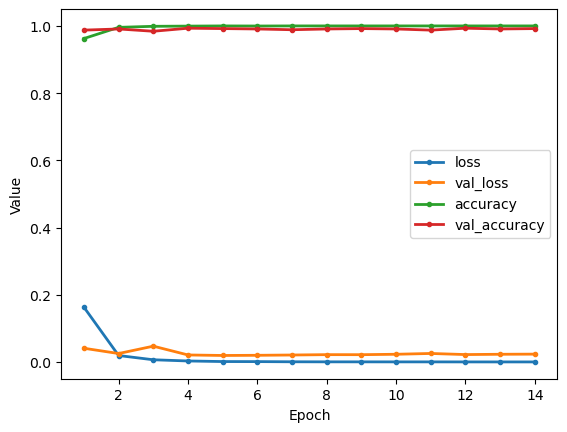

In [18]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [19]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [20]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
3581,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2533,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4587,0.003155,0.0,0.0,0.003155,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1712,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2122,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [22]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      37,435,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,476,353 (142.96 MB)

 Trainable params: 37,476,353 (142.96 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 34s 641ms/step - accuracy: 0.4219 - loss: 0.6931

 2/55 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.4336 - loss: 0.6932 

 3/55 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.4592 - loss: 0.6932

 4/55 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.4733 - loss: 0.6931

 5/55 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.4811 - loss: 0.6931

 6/55 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.4860 - loss: 0.6931

 7/55 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.4887 - loss: 0.6931

 8/55 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.4915 - loss: 0.6930

 9/55 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.4929 - loss: 0.6930

10/55 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.4933 - loss: 0.6930

11/55 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.4936 - loss: 0.6930

12/55 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.4935 - loss: 0.6930

13/55 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.4934 - loss: 0.6930

14/55 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.4934 - loss: 0.6929

15/55 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.4944 - loss: 0.6929

16/55 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.4964 - loss: 0.6928

17/55 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.4991 - loss: 0.6928

18/55 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.5024 - loss: 0.6927

19/55 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.5062 - loss: 0.6926

20/55 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.5104 - loss: 0.6925

21/55 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.5146 - loss: 0.6924

22/55 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.5191 - loss: 0.6923

23/55 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.5238 - loss: 0.6921

24/55 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.5284 - loss: 0.6920

25/55 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.5331 - loss: 0.6918

26/55 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.5375 - loss: 0.6916

27/55 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.5416 - loss: 0.6914

28/55 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.5457 - loss: 0.6912

29/55 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.5496 - loss: 0.6910

30/55 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.5534 - loss: 0.6907

31/55 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.5572 - loss: 0.6904

32/55 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.5608 - loss: 0.6902

33/55 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.5644 - loss: 0.6898

34/55 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.5679 - loss: 0.6895

35/55 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.5714 - loss: 0.6892

36/55 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.5747 - loss: 0.6888

37/55 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.5781 - loss: 0.6884

38/55 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.5814 - loss: 0.6880

39/55 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.5847 - loss: 0.6875

40/55 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.5879 - loss: 0.6870

41/55 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.5910 - loss: 0.6865

42/55 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.5941 - loss: 0.6859

43/55 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.5971 - loss: 0.6853

44/55 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.6001 - loss: 0.6846

45/55 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.6030 - loss: 0.6839

46/55 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.6059 - loss: 0.6832

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.6086 - loss: 0.6824

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.6114 - loss: 0.6816

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.6141 - loss: 0.6807

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.6168 - loss: 0.6798

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.6195 - loss: 0.6789

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.6221 - loss: 0.6778

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.6247 - loss: 0.6768

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.6273 - loss: 0.6757

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.6298 - loss: 0.6745

55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - accuracy: 0.6322 - loss: 0.6734 - val_accuracy: 0.9319 - val_loss: 0.3080


Epoch 2/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 13s 249ms/step - accuracy: 0.9375 - loss: 0.3051

 2/55 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9453 - loss: 0.2922 

 3/55 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.9479 - loss: 0.2825

 4/55 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.9512 - loss: 0.2746

 5/55 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 0.9534 - loss: 0.2679

 6/55 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.9560 - loss: 0.2622

 7/55 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.9585 - loss: 0.2566

 8/55 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.9607 - loss: 0.2514

 9/55 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.9624 - loss: 0.2466

10/55 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.9636 - loss: 0.2422

11/55 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.9645 - loss: 0.2381

12/55 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.9653 - loss: 0.2341

13/55 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.9660 - loss: 0.2304

14/55 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.9668 - loss: 0.2267

15/55 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9675 - loss: 0.2231

16/55 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.9681 - loss: 0.2198

17/55 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9685 - loss: 0.2167

18/55 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.9689 - loss: 0.2137

19/55 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.9692 - loss: 0.2109

20/55 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.9696 - loss: 0.2080

21/55 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.9698 - loss: 0.2052

22/55 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.9701 - loss: 0.2025

23/55 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.9704 - loss: 0.1999

24/55 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.9707 - loss: 0.1973

25/55 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9710 - loss: 0.1949

26/55 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9713 - loss: 0.1924

27/55 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9716 - loss: 0.1900

28/55 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.9719 - loss: 0.1878

29/55 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.9722 - loss: 0.1856

30/55 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.9724 - loss: 0.1834

31/55 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9727 - loss: 0.1814

32/55 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9729 - loss: 0.1793

33/55 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9731 - loss: 0.1774

34/55 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9734 - loss: 0.1754

35/55 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9736 - loss: 0.1736

36/55 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9738 - loss: 0.1717

37/55 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9740 - loss: 0.1700

38/55 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.9742 - loss: 0.1683

39/55 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.9744 - loss: 0.1666

40/55 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.9746 - loss: 0.1650

41/55 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.9748 - loss: 0.1634

42/55 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.9750 - loss: 0.1619

43/55 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.9752 - loss: 0.1604

44/55 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.9754 - loss: 0.1589

45/55 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.9755 - loss: 0.1574

46/55 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.9757 - loss: 0.1560

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9759 - loss: 0.1546

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9760 - loss: 0.1533

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9762 - loss: 0.1520

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9763 - loss: 0.1507

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9765 - loss: 0.1494

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9766 - loss: 0.1482

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9768 - loss: 0.1470

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9769 - loss: 0.1458

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9770 - loss: 0.1447

55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 0.9772 - loss: 0.1436 - val_accuracy: 0.9898 - val_loss: 0.0363


Epoch 3/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 9s 177ms/step - accuracy: 1.0000 - loss: 0.0069

 2/55 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 0.0066

 3/55 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 1.0000 - loss: 0.0065

 4/55 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 1.0000 - loss: 0.0065

 5/55 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 0.0063

 6/55 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 0.0062

 7/55 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 0.0062

 8/55 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 0.0061

 9/55 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 0.0060

10/55 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 0.0059

11/55 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 0.0059

12/55 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 0.0059

13/55 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 0.0058

14/55 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 0.0057

15/55 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 0.0057

16/55 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 0.0056

17/55 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 0.0056

18/55 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 0.0055

19/55 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 0.0055

20/55 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 0.0054

21/55 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 0.0053

22/55 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 0.0053

23/55 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 0.0053

24/55 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 0.0052

25/55 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 0.0052

26/55 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 0.0051

27/55 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 0.0051

28/55 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 0.0050

29/55 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 0.0050

30/55 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 0.0050

31/55 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 0.0049

32/55 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 0.0049

33/55 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 0.0049

34/55 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 0.0048

35/55 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 0.0048

36/55 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 0.0048

37/55 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 0.0047

38/55 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 0.0047

39/55 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 0.0047

40/55 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 0.0046

41/55 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 0.0046

42/55 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 0.0046

43/55 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 0.0046

44/55 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 0.0045

45/55 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 0.0045

46/55 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 0.0045

47/55 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 0.0044

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 0.0044

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 0.0044

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 0.0044

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 0.0043

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 0.0043

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 0.0043

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 0.0043

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 0.0043

55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 1.0000 - loss: 0.0042 - val_accuracy: 0.9852 - val_loss: 0.0327


Epoch 4/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step - accuracy: 1.0000 - loss: 0.0013

 2/55 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 0.0011

 3/55 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 0.0012

 4/55 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 1.0000 - loss: 0.0012

 5/55 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 0.0012

 6/55 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 0.0013

 7/55 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 0.0014

 8/55 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 1.0000 - loss: 0.0014

 9/55 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 0.0015

10/55 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 0.0015

11/55 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 0.0015

12/55 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 0.0015

13/55 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 0.0016

14/55 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 0.0016

15/55 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 0.0016

16/55 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 0.0016

17/55 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 0.0016

18/55 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 0.0016

19/55 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 0.0016

20/55 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 0.0016

21/55 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 0.0016

22/55 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 0.0016

23/55 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 0.0016

24/55 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 0.0016

25/55 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 0.0016

26/55 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 0.0016

27/55 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 0.0016

28/55 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 0.0016

29/55 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 0.0016

30/55 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 0.0016

31/55 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 0.0016

32/55 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 0.0016

33/55 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 0.0016

34/55 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 0.0016

35/55 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 0.0016

36/55 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 0.0016

37/55 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 0.0015

38/55 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 0.0015

39/55 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 0.0015

40/55 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 0.0015

41/55 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 0.0015

42/55 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 0.0015

43/55 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 0.0015

44/55 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 0.0015

45/55 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 0.0015

46/55 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 0.0015

47/55 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 0.0015

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 0.0015

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 0.0015

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 0.0015

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 0.0015

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 0.0015

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 0.0015

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 0.0015

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 0.0014

55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9852 - val_loss: 0.0315


Epoch 5/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 8.8434e-04

 2/55 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 1.0000 - loss: 7.4604e-04

 3/55 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 1.0000 - loss: 6.7055e-04

 4/55 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 6.4946e-04

 5/55 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 6.4028e-04

 6/55 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 6.4978e-04

 7/55 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 6.6417e-04

 8/55 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 6.7833e-04

 9/55 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 6.8654e-04

10/55 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 6.8892e-04

11/55 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 6.8841e-04

12/55 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 6.8662e-04

13/55 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 6.8506e-04

14/55 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 6.8455e-04

15/55 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 6.8267e-04

16/55 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 6.8058e-04

17/55 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 6.8097e-04

18/55 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 6.8144e-04

19/55 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 6.8144e-04

20/55 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 6.8047e-04

21/55 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 6.7924e-04

22/55 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 6.7787e-04

23/55 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 6.7680e-04

24/55 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 6.7507e-04

25/55 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 6.7738e-04

26/55 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 6.8000e-04

27/55 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 6.8211e-04

28/55 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 6.8409e-04

29/55 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 6.8555e-04

30/55 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 6.8663e-04

31/55 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 6.9168e-04

32/55 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 6.9592e-04

33/55 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 7.0007e-04

34/55 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 7.0452e-04

35/55 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 7.0861e-04

36/55 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 7.1252e-04

37/55 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 7.1592e-04

38/55 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 7.1880e-04

39/55 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 7.2117e-04

40/55 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 7.2319e-04

41/55 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 7.2481e-04

42/55 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 7.2633e-04

43/55 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 7.2753e-04

44/55 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 7.2855e-04

45/55 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 7.2945e-04

46/55 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 7.3011e-04

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 7.3078e-04

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 7.3133e-04

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 7.3180e-04

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 7.3225e-04

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 7.3256e-04

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 7.3278e-04

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 7.3282e-04

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 7.3269e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 7.3242e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 1.0000 - loss: 7.3216e-04 - val_accuracy: 0.9852 - val_loss: 0.0306


Epoch 6/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 1.0000 - loss: 3.1922e-04

 2/55 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 1.0000 - loss: 3.1182e-04

 3/55 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 1.0000 - loss: 3.3162e-04

 4/55 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 3.4928e-04

 5/55 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 3.5174e-04

 6/55 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 3.4949e-04

 7/55 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 3.6206e-04

 8/55 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 3.7389e-04

 9/55 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 3.8196e-04

10/55 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 3.8877e-04

11/55 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 3.9699e-04

12/55 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 4.0441e-04

13/55 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 4.0939e-04

14/55 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 4.1272e-04

15/55 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 4.1445e-04

16/55 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 4.1588e-04

17/55 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 4.1663e-04

18/55 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 4.1683e-04

19/55 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 4.1649e-04

20/55 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 4.1540e-04

21/55 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 4.1408e-04

22/55 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 4.1257e-04

23/55 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 4.1134e-04

24/55 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 4.1000e-04

25/55 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 4.0915e-04

26/55 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 4.0814e-04

27/55 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 4.0712e-04

28/55 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 4.0691e-04

29/55 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 4.0663e-04

30/55 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 4.0630e-04

31/55 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 4.0585e-04

32/55 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 4.0556e-04

33/55 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 4.0516e-04

34/55 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 4.0549e-04

35/55 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 4.0558e-04

36/55 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 4.0585e-04

37/55 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 4.0617e-04

38/55 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 4.0632e-04

39/55 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 4.0634e-04

40/55 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 4.0624e-04

41/55 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 4.0598e-04

42/55 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 4.0565e-04

43/55 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 4.0528e-04

44/55 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 4.0495e-04

45/55 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 4.0470e-04

46/55 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 4.0437e-04

47/55 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 4.0394e-04

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 4.0353e-04

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 4.0310e-04

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 4.0267e-04

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 4.0224e-04

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 4.0183e-04

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 4.0207e-04

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 4.0224e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 4.0231e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 1.0000 - loss: 4.0238e-04 - val_accuracy: 0.9852 - val_loss: 0.0313


Epoch 7/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 9s 178ms/step - accuracy: 1.0000 - loss: 8.1067e-04

 2/55 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 1.0000 - loss: 6.9383e-04

 3/55 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 1.0000 - loss: 6.5888e-04

 4/55 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 6.1470e-04

 5/55 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 5.8908e-04

 6/55 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 5.6569e-04

 7/55 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 5.4545e-04

 8/55 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 5.4027e-04

 9/55 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 5.4054e-04

10/55 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 5.3752e-04

11/55 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 5.3691e-04

12/55 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 5.3751e-04

13/55 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 5.4013e-04

14/55 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 5.4139e-04

15/55 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 5.4092e-04

16/55 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 5.3897e-04

17/55 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 5.3636e-04

18/55 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 5.3288e-04

19/55 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 5.2907e-04

20/55 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 5.2495e-04

21/55 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 5.2062e-04

22/55 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 5.1639e-04

23/55 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 5.1187e-04

24/55 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 5.0740e-04

25/55 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 5.0304e-04

26/55 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 4.9873e-04

27/55 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 4.9456e-04

28/55 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 4.9049e-04

29/55 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 4.8636e-04

30/55 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 4.8222e-04

31/55 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 4.7832e-04

32/55 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 4.7448e-04

33/55 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 4.7071e-04

34/55 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 4.6700e-04

35/55 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 4.6338e-04

36/55 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 4.5995e-04

37/55 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 4.5671e-04

38/55 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 4.5360e-04

39/55 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 4.5062e-04

40/55 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 4.4770e-04

41/55 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 4.4487e-04

42/55 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 4.4206e-04

43/55 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 4.3939e-04

44/55 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 4.3677e-04

45/55 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 4.3419e-04

46/55 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 4.3163e-04

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 4.2910e-04

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 4.2677e-04

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 4.2445e-04

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 4.2218e-04

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 4.1995e-04

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 4.1775e-04

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 4.1559e-04

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 4.1347e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 4.1137e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 1.0000 - loss: 4.0934e-04 - val_accuracy: 0.9830 - val_loss: 0.0440


Epoch 8/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 12s 225ms/step - accuracy: 1.0000 - loss: 6.4450e-05

 2/55 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 9.8918e-05 

 3/55 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 1.0000 - loss: 1.2284e-04

 4/55 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 1.2792e-04

 5/55 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 1.3223e-04

 6/55 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 1.3359e-04

 7/55 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 1.3619e-04

 8/55 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 1.3671e-04

 9/55 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 1.4011e-04

10/55 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 1.4273e-04

11/55 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 1.4457e-04

12/55 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 1.4539e-04

13/55 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 1.4581e-04

14/55 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 1.4594e-04

15/55 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.4607e-04

16/55 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.4604e-04

17/55 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.4623e-04

18/55 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.4642e-04

19/55 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.4646e-04

20/55 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.4628e-04

21/55 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.4639e-04

22/55 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.4661e-04

23/55 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 1.4728e-04

24/55 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 1.4789e-04

25/55 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 1.4834e-04

26/55 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 1.4862e-04

27/55 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.4879e-04

28/55 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 1.4897e-04

29/55 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 1.4915e-04

30/55 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 1.4958e-04

31/55 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 1.4994e-04

32/55 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 1.5018e-04

33/55 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 1.5054e-04

34/55 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.5077e-04

35/55 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.5098e-04

36/55 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.5113e-04

37/55 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.5128e-04

38/55 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 1.5140e-04

39/55 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 1.5150e-04

40/55 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 1.5160e-04

41/55 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 1.5181e-04

42/55 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 1.5196e-04

43/55 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 1.5214e-04

44/55 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 1.5233e-04

45/55 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 1.5249e-04

46/55 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 1.5264e-04

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 1.5275e-04

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 1.5307e-04

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 1.5336e-04

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 1.5365e-04

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 1.5390e-04

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 1.5412e-04

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 1.5435e-04

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 1.5456e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 1.5476e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 1.0000 - loss: 1.5495e-04 - val_accuracy: 0.9852 - val_loss: 0.0349


Epoch 9/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 9s 183ms/step - accuracy: 1.0000 - loss: 1.8656e-04

 2/55 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 1.0000 - loss: 1.6257e-04

 3/55 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - accuracy: 1.0000 - loss: 1.5155e-04

 4/55 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 1.4764e-04

 5/55 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 1.4616e-04

 6/55 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 1.4390e-04

 7/55 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 1.4363e-04

 8/55 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 1.4219e-04

 9/55 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 1.4353e-04

10/55 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 1.4364e-04

11/55 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 1.4361e-04

12/55 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 1.4312e-04

13/55 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 1.4241e-04

14/55 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.4193e-04

15/55 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 1.4142e-04

16/55 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.4122e-04

17/55 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.4160e-04

18/55 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.4201e-04

19/55 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.4258e-04

20/55 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 1.4305e-04

21/55 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 1.4329e-04

22/55 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 1.4335e-04

23/55 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 1.4324e-04

24/55 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 1.4303e-04

25/55 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 1.4283e-04

26/55 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 1.4256e-04

27/55 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 1.4227e-04

28/55 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 1.4188e-04

29/55 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 1.4144e-04

30/55 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 1.4104e-04

31/55 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 1.4058e-04

32/55 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 1.4007e-04

33/55 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 1.3960e-04

34/55 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 1.3911e-04

35/55 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 1.3859e-04

36/55 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 1.3812e-04

37/55 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 1.3763e-04

38/55 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.3714e-04

39/55 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 1.3663e-04

40/55 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 1.3628e-04

41/55 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 1.3590e-04

42/55 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 1.3556e-04

43/55 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 1.3521e-04

44/55 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 1.3485e-04

45/55 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 1.3454e-04

46/55 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 1.3423e-04

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.3393e-04

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 1.3362e-04

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 1.3336e-04

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 1.3308e-04

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 1.3279e-04

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 1.3252e-04

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 1.3223e-04

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 1.3194e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 1.3164e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 1.3135e-04 - val_accuracy: 0.9841 - val_loss: 0.0413


Epoch 10/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - accuracy: 1.0000 - loss: 6.1681e-05

 2/55 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 5.7700e-05

 3/55 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 1.0000 - loss: 5.6171e-05

 4/55 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 1.0000 - loss: 5.7726e-05

 5/55 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 1.0000 - loss: 7.5655e-05

 6/55 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 8.5357e-05

 7/55 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 9.1095e-05

 8/55 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 9.3980e-05

 9/55 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 9.7042e-05

10/55 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 1.0016e-04

11/55 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 1.0358e-04

12/55 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 1.0586e-04

13/55 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 1.0777e-04

14/55 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 1.0905e-04

15/55 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 1.0998e-04

16/55 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.1050e-04

17/55 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.1105e-04

18/55 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 1.1142e-04

19/55 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 1.1156e-04

20/55 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.1166e-04

21/55 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.1164e-04

22/55 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.1152e-04

23/55 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.1134e-04

24/55 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 1.1123e-04

25/55 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.1107e-04

26/55 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 1.1087e-04

27/55 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 1.1064e-04

28/55 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 1.1032e-04

29/55 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 1.0994e-04

30/55 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 1.0955e-04

31/55 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 1.0926e-04

32/55 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 1.0895e-04

33/55 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 1.0869e-04

34/55 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 1.0839e-04

35/55 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 1.0807e-04

36/55 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 1.0773e-04

37/55 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 1.0739e-04

38/55 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 1.0702e-04

39/55 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 1.0665e-04

40/55 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 1.0626e-04

41/55 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 1.0587e-04

42/55 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.0547e-04

43/55 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 1.0508e-04

44/55 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.0485e-04

45/55 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.0458e-04

46/55 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 1.0431e-04

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.0404e-04

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.0376e-04

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.0349e-04

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.0321e-04

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.0293e-04

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.0267e-04

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.0242e-04

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 1.0216e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 1.0190e-04

55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 1.0164e-04 - val_accuracy: 0.9841 - val_loss: 0.0386


Epoch 11/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - accuracy: 1.0000 - loss: 9.4149e-05

 2/55 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 1.0000 - loss: 8.2316e-05

 3/55 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 1.0000 - loss: 7.3033e-05

 4/55 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 1.0000 - loss: 6.8147e-05

 5/55 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 1.0000 - loss: 6.4922e-05

 6/55 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 1.0000 - loss: 6.4033e-05

 7/55 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 1.0000 - loss: 6.5689e-05

 8/55 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 6.6778e-05

 9/55 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 1.0000 - loss: 6.7087e-05

10/55 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 1.0000 - loss: 6.7683e-05

11/55 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 1.0000 - loss: 6.8814e-05

12/55 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 1.0000 - loss: 6.9908e-05

13/55 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 7.0742e-05

14/55 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 7.1535e-05

15/55 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 7.2496e-05

16/55 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 7.3159e-05

17/55 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 7.3725e-05

18/55 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 7.4066e-05

19/55 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 7.4354e-05

20/55 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 7.4652e-05

21/55 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 7.4881e-05

22/55 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 7.5011e-05

23/55 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 7.5102e-05

24/55 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 7.5138e-05

25/55 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 7.5105e-05

26/55 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 7.5087e-05

27/55 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 7.4985e-05

28/55 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 7.4872e-05

29/55 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 7.4730e-05

30/55 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 7.4570e-05

31/55 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 7.4363e-05

32/55 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 7.4142e-05

33/55 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 7.3920e-05

34/55 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 7.3681e-05

35/55 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 7.3469e-05

36/55 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 7.3242e-05

37/55 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 7.3064e-05

38/55 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 7.2884e-05

39/55 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 7.2691e-05

40/55 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 7.2490e-05

41/55 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 7.2280e-05

42/55 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 7.2062e-05

43/55 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 7.1842e-05

44/55 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 7.1623e-05

45/55 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 7.1421e-05

46/55 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 7.1234e-05

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 7.1074e-05

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 7.0905e-05

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 7.0728e-05

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 7.0569e-05

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 7.0410e-05

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 7.0254e-05

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 7.0091e-05

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 6.9928e-05

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 6.9769e-05

55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 6.9615e-05 - val_accuracy: 0.9841 - val_loss: 0.0439


Epoch 12/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 8s 164ms/step - accuracy: 1.0000 - loss: 4.1206e-05

 2/55 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 1.0000 - loss: 4.0152e-05

 3/55 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 4.3665e-05

 4/55 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 4.5533e-05

 5/55 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 4.6545e-05

 6/55 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 4.7099e-05

 7/55 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 5.0204e-05

 8/55 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 5.2010e-05

 9/55 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 5.3551e-05

10/55 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 5.4782e-05

11/55 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 5.5451e-05

12/55 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 1.0000 - loss: 5.6158e-05

13/55 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 1.0000 - loss: 5.6877e-05

14/55 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 5.7285e-05

15/55 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 5.7557e-05

16/55 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 5.7834e-05

17/55 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 5.7964e-05

18/55 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 5.8333e-05

19/55 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 5.8522e-05

20/55 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 5.8712e-05

21/55 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 5.8882e-05

22/55 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 5.9062e-05

23/55 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 5.9148e-05

24/55 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 5.9199e-05

25/55 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 5.9298e-05

26/55 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 5.9385e-05

27/55 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 5.9445e-05

28/55 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 5.9460e-05

29/55 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 5.9503e-05

30/55 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 5.9522e-05

31/55 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 5.9497e-05

32/55 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 5.9454e-05

33/55 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 5.9463e-05

34/55 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 5.9430e-05

35/55 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 5.9364e-05

36/55 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 5.9287e-05

37/55 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 5.9192e-05

38/55 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 5.9085e-05

39/55 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 5.8973e-05

40/55 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 5.8851e-05

41/55 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 5.8719e-05

42/55 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 5.8580e-05

43/55 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 5.8435e-05

44/55 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 5.8295e-05

45/55 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 5.8141e-05

46/55 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 5.7981e-05

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 5.7819e-05

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 5.7649e-05

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 5.7488e-05

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 5.7330e-05

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 5.7174e-05

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 5.7017e-05

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 5.6860e-05

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 5.6698e-05

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 5.6535e-05

55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 5.6376e-05 - val_accuracy: 0.9841 - val_loss: 0.0436



[Train Accuracy: 100.00% - Test Accuracy: 99.00%]


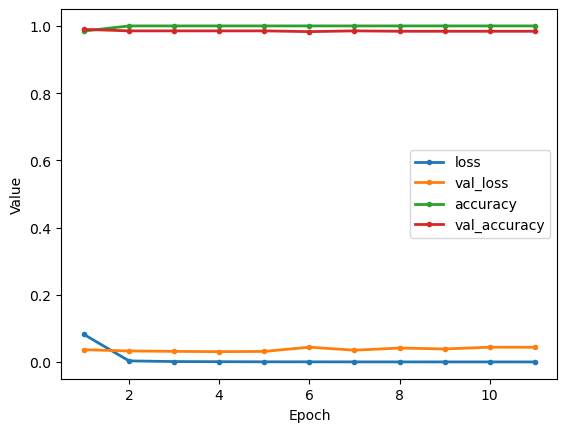

In [23]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [24]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/35 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step

 6/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

12/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

17/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

22/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

27/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 1/35 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step

 6/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

11/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

16/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

20/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

24/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

26/35 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

31/35 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


In [25]:
report.save()

Report saved as Output/Reports/Nin-like/report_5VOGFWS9.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [26]:
"""k = 5
X, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()"""

"k = 5\nX, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)\nX_test.head()"

In [27]:
"""NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]"""

'NUM_CLASS  = 1\nSEQ_LENGTH = X_train.shape[1]'

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [28]:
"""name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'name="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n# Evaluate and sc

In [29]:
"""VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"""

"VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"

In [30]:
"""VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('end')"""

'VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) \nreport.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])\nreport.save(\'end\')'

In [31]:
# END

In [32]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################